In [1]:
import cv2 

img = cv2.imread('./dataset-flowers\\iris\\15020790_f8aaf8850b_c.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

256 256 3 3


# Convolutional Neural Networks

# Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [4]:
dirname = os.path.join(os.getcwd(),'./dataset-flowers-Z')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\daven\Documents\ITMorelia\Semestre IX\Inteligencia Artificial\IA\Inteligencia-Artificial\Proyecto\./dataset-flowers-Z\
C:\Users\daven\Documents\ITMorelia\Semestre IX\Inteligencia Artificial\IA\Inteligencia-Artificial\Proyecto\./dataset-flowers-Z\astilbe 1
C:\Users\daven\Documents\ITMorelia\Semestre IX\Inteligencia Artificial\IA\Inteligencia-Artificial\Proyecto\./dataset-flowers-Z\iris 8712
C:\Users\daven\Documents\ITMorelia\Semestre IX\Inteligencia Artificial\IA\Inteligencia-Artificial\Proyecto\./dataset-flowers-Z\rose 12492
C:\Users\daven\Documents\ITMorelia\Semestre IX\Inteligencia Artificial\IA\Inteligencia-Artificial\Proyecto\./dataset-flowers-Z\sunflower 16728
C:\Users\daven\Documents\ITMorelia\Semestre IX\Inteligencia Artificial\IA\Inteligencia-Artificial\Proyecto\./dataset-flowers-Z\tulip 17460
Directorios leidos: 5
Imagenes en cada directorio [8713, 12492, 16728, 17460, 17003]
suma Total de imagenes en subdirs: 72396


# Creamos las etiquetas

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  72396


In [6]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 astilbe
1 iris
2 rose
3 sunflower
4 tulip


In [7]:
resize_images = [cv2.resize(img, (28,28)) for img in images]
y = np.array(labels)
X = np.array(resize_images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [8]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (57916, 28, 28, 3) (57916,)
Testing data shape :  (14480, 28, 28, 3) (14480,)


Text(0.5, 1.0, 'Ground Truth : 3')

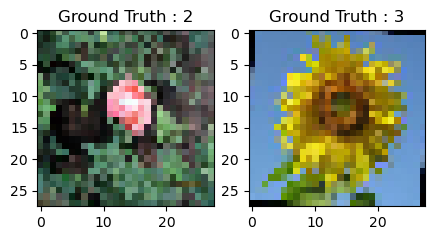

In [9]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

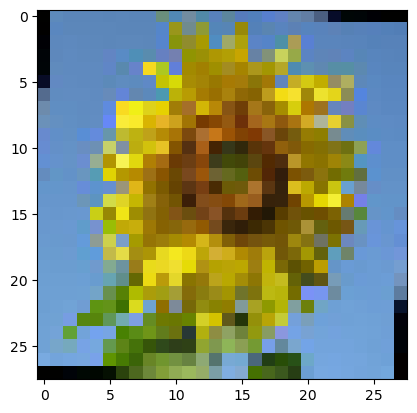

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [11]:
#from tensorflow.keras.utils import to_categorical

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [12]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [13]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(46332, 28, 28, 3) (11584, 28, 28, 3) (46332, 5) (11584, 5)


# Creamos el modelo de CNN

In [14]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 100 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 50 # cantidad de imágenes que se toman a la vez en memoria

In [15]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [16]:
sport_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 32)                200736    
                                                        

In [17]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [18]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100


927/927 [==============================] - 25s 25ms/step - loss: 1.5332 - accuracy: 0.3047 - val_loss: 1.4017 - val_accuracy: 0.4391
Epoch 2/100
927/927 [==============================] - 23s 25ms/step - loss: 1.3536 - accuracy: 0.4261 - val_loss: 1.1721 - val_accuracy: 0.5793
Epoch 3/100
927/927 [==============================] - 22s 24ms/step - loss: 1.1934 - accuracy: 0.5104 - val_loss: 1.0381 - val_accuracy: 0.6165
Epoch 4/100
927/927 [==============================] - 22s 24ms/step - loss: 1.0967 - accuracy: 0.5551 - val_loss: 0.9654 - val_accuracy: 0.6377
Epoch 5/100
927/927 [==============================] - 23s 24ms/step - loss: 1.0375 - accuracy: 0.5841 - val_loss: 0.9201 - val_accuracy: 0.6510
Epoch 6/100
927/927 [==============================] - 20s 22ms/step - loss: 0.9944 - accuracy: 0.6087 - val_loss: 0.8813 - val_accuracy: 0.6670
Epoch 7/100
927/927 [==============================] - 342s 369ms/step - loss: 0.9614 - accuracy: 0.6246 - val_loss: 0.8538 - va

927/927 [==============================] - 22s 24ms/step - loss: 0.7009 - accuracy: 0.7369 - val_loss: 0.6207 - val_accuracy: 0.7695
Epoch 55/100
927/927 [==============================] - 22s 23ms/step - loss: 0.6999 - accuracy: 0.7394 - val_loss: 0.6181 - val_accuracy: 0.7746
Epoch 56/100
927/927 [==============================] - 21s 23ms/step - loss: 0.6974 - accuracy: 0.7396 - val_loss: 0.6156 - val_accuracy: 0.7730
Epoch 57/100
927/927 [==============================] - 21s 23ms/step - loss: 0.6951 - accuracy: 0.7410 - val_loss: 0.6132 - val_accuracy: 0.7742
Epoch 58/100
927/927 [==============================] - 21s 23ms/step - loss: 0.6938 - accuracy: 0.7408 - val_loss: 0.6111 - val_accuracy: 0.7752
Epoch 59/100
927/927 [==============================] - 21s 22ms/step - loss: 0.6918 - accuracy: 0.7405 - val_loss: 0.6096 - val_accuracy: 0.7756
Epoch 60/100
927/927 [==============================] - 21s 23ms/step - loss: 0.6887 - accuracy: 0.7433 - val_loss: 0.6095 - val_accuracy

In [19]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("./flowers-Z.h5py")

INFO:tensorflow:Assets written to: ./flowers-Z.h5py\assets


INFO:tensorflow:Assets written to: ./flowers-Z.h5py\assets


# Evaluamos la red

In [20]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

453/453 [==============================] - 3s 6ms/step - loss: 0.5331 - accuracy: 0.8069


In [21]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5331022143363953
Test accuracy: 0.8069061040878296


In [22]:
sport_train.history

{'loss': [1.5331916809082031,
  1.3536404371261597,
  1.1934337615966797,
  1.096656322479248,
  1.0374691486358643,
  0.9944425225257874,
  0.9614498615264893,
  0.9370350241661072,
  0.9186072945594788,
  0.8981098532676697,
  0.885310709476471,
  0.8735491037368774,
  0.8631121516227722,
  0.8539860844612122,
  0.8400887250900269,
  0.8338133692741394,
  0.8273587822914124,
  0.820267379283905,
  0.8146005868911743,
  0.8096045255661011,
  0.8036720752716064,
  0.7967983484268188,
  0.7954479455947876,
  0.788624107837677,
  0.7839127779006958,
  0.7800438404083252,
  0.77655029296875,
  0.7749688029289246,
  0.7690319418907166,
  0.764799177646637,
  0.7617641091346741,
  0.7572697401046753,
  0.7566283941268921,
  0.7530494332313538,
  0.7531501650810242,
  0.7484895586967468,
  0.7421939969062805,
  0.7414902448654175,
  0.7371712923049927,
  0.7325380444526672,
  0.7317063212394714,
  0.7299789786338806,
  0.7282626032829285,
  0.7241456508636475,
  0.7222423553466797,
  0.72064

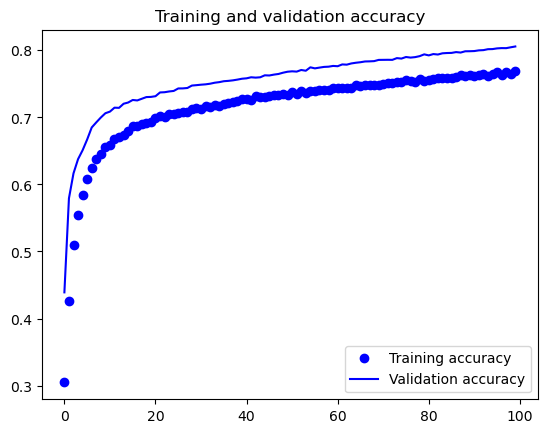

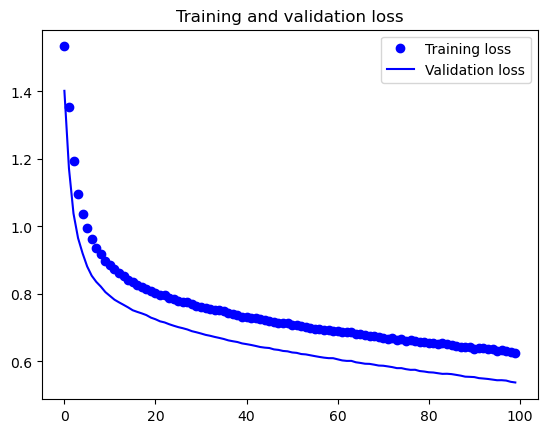

In [23]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
predicted_classes2 = sport_model.predict(test_X)

453/453 [==============================] - 3s 6ms/step


In [25]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [26]:
predicted_classes.shape, test_Y.shape

((14480,), (14480,))

# Aprendamos de los errores: Qué mejorar

Found 11684 correct labels


C:\Users\daven\AppData\Local\Temp\ipykernel_2412\2312090548.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


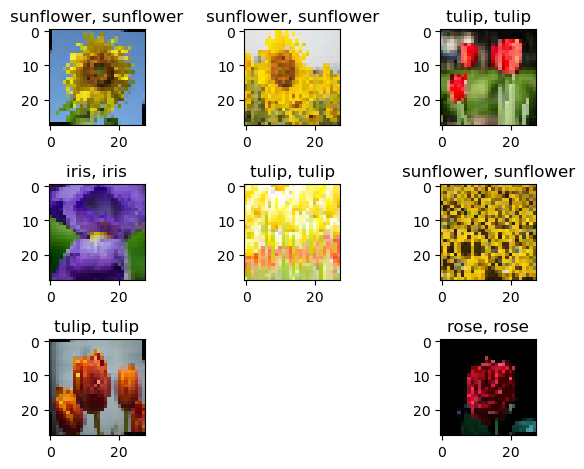

In [27]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 2796 incorrect labels


C:\Users\daven\AppData\Local\Temp\ipykernel_2412\1639673630.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


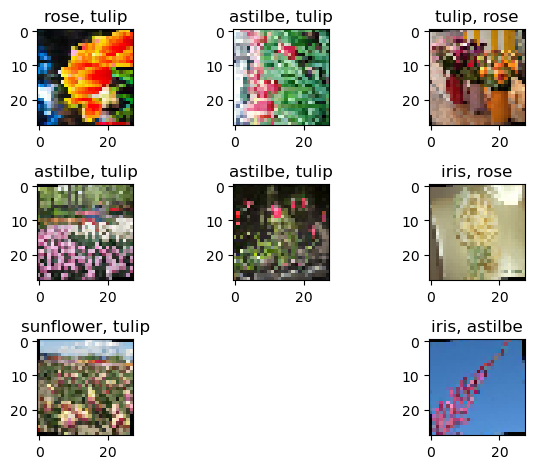

In [28]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [29]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.69      0.69      0.69      1767
     Class 1       0.91      0.90      0.90      2523
     Class 2       0.74      0.75      0.75      3413
     Class 3       0.90      0.96      0.93      3443
     Class 4       0.76      0.70      0.73      3334

    accuracy                           0.81     14480
   macro avg       0.80      0.80      0.80     14480
weighted avg       0.80      0.81      0.81     14480



In [54]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['./test\\iris1.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (28, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

1/1 [==============================] - 0s 47ms/step
./test\iris1.jpg iris
